In [40]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore')
import numpy as np

import os
dfo=pd.DataFrame()

for f in os.listdir('./DataSource/Huazhu/')[-6:]:
    print(f)
    date=f.split('_')[-1].split('.')[0]
    d=pd.read_csv('./DataSource/Huazhu\%s' % f)
    d['date']=date
    dfo=pd.concat([dfo,d],axis=0)

old=pd.read_hdf(r'Processed_Data/hotel.h5',key='0105')
new=pd.concat([old,dfo])
new=new.drop_duplicates()
new.to_hdf(r'Processed_Data/hotel.h5',key='0105')

huazhu_stock_2023-01-04.csv
huazhu_stock_2023-01-05.csv
huazhu_stock_2023-01-06.csv
huazhu_stock_2023-01-07.csv
huazhu_stock_2023-01-08.csv
huazhu_stock_2023-01-09.csv


In [41]:
# 店铺也用同店的
c1=new['date'].astype('str')<'2022-07-01'
hotellist=new[c1]['hotelId'].drop_duplicates()

c2=new['hotelId'].isin(hotellist)
new=new[c2]

In [42]:
d=new.copy()
c1=d['brandLevel'].isin(['经济型','舒适型'])
d=d[c1][['date','cityId', 'cityName', 'brandLevel', 'hotelId', 'hotelName', 'roomName','checkInType', 'stock']]
d['checkInType']=d['checkInType'].replace('later','future')
d1=d.groupby(by=['date','cityName', 'brandLevel','hotelName','checkInType','roomName']).mean().reset_index()
d1=d1.groupby(by=['date','cityName', 'brandLevel','checkInType','hotelName']).sum().reset_index()
pv=pd.pivot_table(d1,index=['date','cityName','hotelName'],values='stock',columns='checkInType', aggfunc=np.sum).reset_index()
pv=pv[~pv['now'].isna()]
pv=pv[~pv['future'].isna()]
pv['bookedNights']=pv['future']-pv['now']
pv['hotel_occ']=pv['bookedNights']/pv['future']
c2=pv['now']>5
c3=pv['hotel_occ']<=1

pv2=pv[c2&c3]
pv2=pv2.groupby(by=['date','cityName']).sum().reset_index()
pv2['city_occ']=pv2['bookedNights']/pv2['future']
pv2=pv2.drop(columns='hotel_occ')

pv2

checkInType,date,cityName,future,now,bookedNights,city_occ
0,2022-06-07,万宁,67.0,20.0,47.0,0.701493
1,2022-06-07,三亚,529.0,241.0,288.0,0.544423
2,2022-06-07,三原县,79.0,32.0,47.0,0.594937
3,2022-06-07,三明,145.0,90.0,55.0,0.379310
4,2022-06-07,三河,229.0,60.0,169.0,0.737991
...,...,...,...,...,...,...
150770,2023-01-09,龙口,212.0,72.0,140.0,0.660377
150771,2023-01-09,龙岩,250.0,97.0,153.0,0.612000
150772,2023-01-09,龙泉,77.0,42.0,35.0,0.454545
150773,2023-01-09,龙港,214.0,84.0,130.0,0.607477


In [43]:
#prepare DF
hotel=pv2
hotel['date']=pd.to_datetime(hotel['date'])
hotel['cityName']=hotel['cityName'].str.replace('市','')

hotel1=hotel.sort_values(by=['cityName','date'])
hotel1['bookedNights_last7d_mean']=hotel1.groupby('cityName')['bookedNights'].transform(lambda x: x.rolling(7, 7).mean())
hotel1['future_last7d_mean']=hotel1.groupby('cityName')['future'].transform(lambda x: x.rolling(7, 7).mean())

hotel1['bookedNights_change_WoW']=(hotel1['bookedNights_last7d_mean']/hotel1.groupby('cityName')['bookedNights_last7d_mean'].transform(lambda x: x.shift(periods=7)))-1

c1=hotel1['date'].astype('str')< '2022-10-01'
c2=hotel1['bookedNights']>0
june_mean=hotel1[c1&c2].groupby('cityName').mean().reset_index().sort_values(by='bookedNights')[['cityName','bookedNights']].reset_index(drop=True)
june_mean.columns=['cityName', 'bookedNights_june']

hotel1=hotel1.merge(june_mean,on='cityName')
hotel1['changes_since_june']=hotel1['bookedNights_last7d_mean']/hotel1['bookedNights_june']

#occ changes
hotel1['city_occ_last7d_mean']=hotel1.groupby('cityName')['city_occ'].transform(lambda x: x.rolling(7, 7).mean())
hotel1['city_occ_change_WoW']=(hotel1['city_occ_last7d_mean']/hotel1.groupby('cityName')['city_occ_last7d_mean'].transform(lambda x: x.shift(periods=7)))-1

c1=hotel1['date'].astype('str')< '2022-10-01'
c2=hotel1['bookedNights']>0
june_mean_occ=hotel1[c1&c2].groupby('cityName').mean().reset_index()[['cityName','city_occ']].reset_index(drop=True)
june_mean_occ.columns=['cityName', 'occ_june']

hotel1=hotel1.merge(june_mean_occ,on='cityName')

hotel1['changes_since_june_occ']=hotel1['city_occ_last7d_mean']/hotel1['occ_june']
hotel1

,date,cityName,future,now,bookedNights,city_occ,bookedNights_last7d_mean,future_last7d_mean,bookedNights_change_WoW,bookedNights_june,changes_since_june,city_occ_last7d_mean,city_occ_change_WoW,occ_june,changes_since_june_occ
0,2022-06-08,七台河,86.0,26.0,60.0,0.697674,NaN,NaN,NaN,65.687500,NaN,NaN,NaN,0.763808,NaN
1,2022-06-09,七台河,86.0,13.0,73.0,0.848837,NaN,NaN,NaN,65.687500,NaN,NaN,NaN,0.763808,NaN
2,2022-06-10,七台河,86.0,27.0,59.0,0.686047,NaN,NaN,NaN,65.687500,NaN,NaN,NaN,0.763808,NaN
3,2022-06-11,七台河,86.0,40.0,46.0,0.534884,NaN,NaN,NaN,65.687500,NaN,NaN,NaN,0.763808,NaN
4,2022-06-12,七台河,86.0,24.0,62.0,0.720930,NaN,NaN,NaN,65.687500,NaN,NaN,NaN,0.763808,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150423,2023-01-05,龙游县,233.0,142.0,91.0,0.390558,74.142857,233.0,0.027723,110.084337,0.673510,0.318210,0.027723,0.485523,0.655395
150424,2023-01-06,龙游县,233.0,155.0,78.0,0.334764,74.285714,233.0,0.078838,110.084337,0.674807,0.318823,0.078838,0.485523,0.656658
150425,2023-01-07,龙游县,233.0,137.0,96.0,0.412017,77.285714,233.0,0.148620,110.084337,0.702059,0.331698,0.148620,0.485523,0.683177
150426,2023-01-08,龙游县,233.0,166.0,67.0,0.287554,78.714286,233.0,0.203057,110.084337,0.715036,0.337830,0.203057,0.485523,0.695805


<AxesSubplot: >

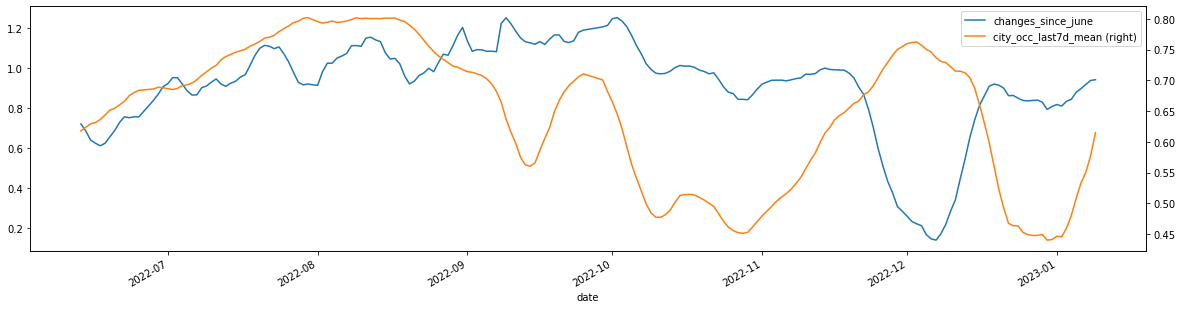

In [44]:
dfp=hotel1[hotel1['cityName']=='北京']
ax = dfp.plot('date','changes_since_june')
dfp.plot('date','city_occ_last7d_mean',secondary_y=True, ax=ax, figsize=(20,5))


In [51]:
# # covid rank vs. hotel nights WoW
# %load_ext autoreload
# %autoreload 2
# from colored_list import dafeng_city,jidui_city,riqi
# # riqi='2022-12-29'

# df_covid=pd.read_hdf('Processed_Data/Baidu_covid_progress.h5',key='raw')

# hotel2=hotel1.merge(df_covid,left_on=['cityName'],right_on=['城市'],how='left')

# hotel2['date']=hotel2['date'].astype('string')
# hotel2=hotel2[hotel2['date']==riqi].sort_values(by='bookedNights_last7d_mean',ascending=False)
# hotel2=hotel2[hotel2['bookedNights_change_WoW']<2].head(70).reset_index()

# o=hotel2[['cityName',  'progress_2','bookedNights_change_WoW']]


# o['size']=np.nan
# o['group']='其他'

# c1=o['cityName'].isin(dafeng_city)
# o.loc[c1,'group']='本波疫情基本结束'

# o=o.sort_values(by='group',ascending=False)

# o.to_clipboard(index=False,header=None)
# print(riqi)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-01-09


In [46]:
# # covid rank vs. hotel nights vs 202206

# df_covid=pd.read_hdf('Processed_Data/Baidu_covid_progress.h5',key='raw')

# hotel2=hotel1.merge(df_covid,left_on=['cityName'],right_on=['城市'],how='left')

# hotel2['date']=hotel2['date'].astype('string')
# hotel2=hotel2[hotel2['date']==riqi].sort_values(by='bookedNights_last7d_mean',ascending=False)
# hotel2=hotel2[hotel2['changes_since_june']<2].head(70).reset_index()

# o=hotel2[['cityName',  'progress_2','changes_since_june']]


# o['size']=np.nan
# o['group']='其他'

# c1=o['cityName'].isin(dafeng_city)
# o.loc[c1,'group']='本波疫情基本结束'

# o=o.sort_values(by='group',ascending=False)

# o.to_clipboard(index=False,header=None)
# print(riqi)


# # d

2023-01-08


In [52]:
# GDP vs. hotel nights WoW

%load_ext autoreload
%autoreload 2
from colored_list import dafeng_city,jidui_city,riqi
# riqi='2022-12-29'

city_popu=pd.read_hdf('Processed_Data/citypopu.h5',key='raw2')

hotel2=hotel1.merge(city_popu,left_on=['cityName'],right_on=['城市'],how='left')

hotel2['date']=hotel2['date'].astype('string')
hotel2=hotel2[hotel2['date']==riqi].sort_values(by='bookedNights_last7d_mean',ascending=False)
hotel2=hotel2[hotel2['bookedNights_change_WoW']<2].head(70).reset_index()

o=hotel2[['cityName',  'GDP','bookedNights_change_WoW']]

o['size']=np.nan
o['group']='其他'

c1=o['cityName'].isin(dafeng_city)
o.loc[c1,'group']='本波疫情基本结束'

o=o.sort_values(by='group',ascending=False)

o.to_clipboard(index=False,header=None)
print(riqi)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-01-09


In [62]:
# GDP vs. hotel nights vs 202206

city_popu=pd.read_hdf('Processed_Data/citypopu.h5',key='raw2')

hotel2=hotel1.merge(city_popu,left_on=['cityName'],right_on=['城市'],how='left')

hotel2['date']=hotel2['date'].astype('string')
hotel2=hotel2[hotel2['date']==riqi].sort_values(by='bookedNights_last7d_mean',ascending=False)
hotel2=hotel2[hotel2['changes_since_june']<2].head(70).reset_index()

o=hotel2[['cityName',  'GDP','changes_since_june']]


o['size']=np.nan
o['group']='其他'

c1=o['cityName'].isin(dafeng_city)
o.loc[c1,'group']='本波疫情基本结束'

o=o.sort_values(by='group',ascending=False)

o.to_clipboard(index=False,header=None)

d=hotel1[hotel1['date']==riqi][['cityName','date','changes_since_june']].reset_index(drop=True).rename(columns={'cityName':'城市','changes_since_june':'hotel'})
d['date']=pd.to_datetime(d['date'])
d.to_hdf('Processed_Data/city_compare.h5',key='hotel')

print(riqi)

2023-01-09


In [49]:
pv2

checkInType,date,cityName,future,now,bookedNights,city_occ
0,2022-06-07,万宁,67.0,20.0,47.0,0.701493
1,2022-06-07,三亚,529.0,241.0,288.0,0.544423
2,2022-06-07,三原县,79.0,32.0,47.0,0.594937
3,2022-06-07,三明,145.0,90.0,55.0,0.379310
4,2022-06-07,三河,229.0,60.0,169.0,0.737991
...,...,...,...,...,...,...
150770,2023-01-09,龙口,212.0,72.0,140.0,0.660377
150771,2023-01-09,龙岩,250.0,97.0,153.0,0.612000
150772,2023-01-09,龙泉,77.0,42.0,35.0,0.454545
150773,2023-01-09,龙港,214.0,84.0,130.0,0.607477


In [61]:
# d1=pd.read_clipboard()
# d1.to_hdf('Processed_Data/tablehead.h5','hotel')

d1=pd.read_hdf('Processed_Data/tablehead.h5','hotel')
d2=pd.pivot_table(pv2[pv2['date']>='2022-11-01'],index='cityName',columns='date',values='bookedNights',aggfunc='sum').reset_index()
d1.merge(d2,left_on='城市',right_on='cityName',how='left').drop(columns=['城市','cityName']).to_clipboard(index=False)